<a href="https://colab.research.google.com/github/dustoff06/ComputerVision/blob/main/CycleGAN_Monet_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Generation using GANs
This lecture covers how to use Generative Adversarial Networks (GANs) for image generation, focusing on applying these concepts to the Kaggle 'Monet' competition.

## Overview of GANs
Generative Adversarial Networks (GANs) are a class of neural networks designed by Ian Goodfellow in 2014 to generate realistic data.
- **Two Networks**: Generator and Discriminator
- **Adversarial Process**: Generator tries to create fake data, while the Discriminator tries to detect fake data.

## Architecture of GANs
**Generator**: Takes random noise as input and generates realistic images.

**Discriminator**: Takes an image (real or generated) and classifies it as real or fake.

**Objective**: Train the Generator to create images that the Discriminator cannot distinguish from real images.

# Training Order

The order of training between the Generator and Discriminator is crucial in the training of GANs. Here’s the explanation of which one to train first and why:

The Correct Order: Discriminator First, Then Generator
Typically, the correct approach is to train the Discriminator first on real and generated (fake) images, and then train the Generator using the Discriminator’s feedback. Let's break down why this order works best.

The Discriminator's job is to distinguish between real images and fake images generated by the Generator.
We train the Discriminator first so it can learn to differentiate between real and fake images effectively.
During this step:
We feed the Discriminator real images and label them as "real" (using labels of 1).
We also feed it fake images generated by the Generator and label them as "fake" (using labels of 0).
The Discriminator is updated to minimize the loss between its predictions and the true labels.

Once the Discriminator has been updated, we freeze its weights and focus on training the Generator.
The Generator tries to fool the Discriminator by generating images that are as realistic as possible.
During this step:
We pass random noise through the Generator to produce fake images.
These generated images are then fed into the Discriminator (with its weights frozen).
We calculate the loss based on how well the generated images were able to fool the Discriminator (i.e., we want the Discriminator to classify them as "real").
The Generator is updated to minimize this loss, effectively improving its ability to generate more realistic images.
Why Train the Discriminator First?

Improving Discriminator Accuracy: If the Discriminator is not well-trained, it won’t be able to provide meaningful feedback to the Generator. This feedback is crucial for the Generator to learn and improve.

Avoiding Mode Collapse: If the Generator is trained too aggressively without a strong Discriminator, it may collapse into producing a limited set of outputs that consistently fool the Discriminator. A well-trained Discriminator helps prevent this by forcing the Generator to be more diverse.

Stabilizing GAN Training: Training the Discriminator first helps stabilize the overall GAN training process. It ensures that the Generator receives meaningful gradients and avoids the risk of generating low-quality outputs.

## Loss Function for GANs
- **Generator Loss**: Minimize `log(1 - D(G(z)))`
- **Discriminator Loss**: Maximize `log(D(x)) + log(1 - D(G(z)))`

Optimization aims to find Nash Equilibrium between the Generator and Discriminator.

In a standard GAN setup, the Generator and Discriminator are playing a two-player game where one tries to minimize the loss, and the other tries to maximize it. The objective is formulated as a minimax game:

$$
\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]
$$

Definition of Nash Equilibrium
In game theory, a Nash Equilibrium occurs when two or more players reach a situation where no player can benefit by changing their strategy unilaterally, given that the other players' strategies remain unchanged.

How Nash Equilibrium Applies to GANs

The Generator and Discriminator are playing a zero-sum game, where the gain of one is the loss of the other.

The Generator wants to minimize the Discriminator's ability to distinguish real from fake images.

The Discriminator wants to maximize its ability to correctly classify real versus fake images.

At Nash Equilibrium: Fake are indistinguishable from real.



## Setting Up the Environment in Colab

In [1]:
!pip install tensorflow-addons kaggle

## Downloading the Dataset from Kaggle
Ensure your Kaggle API key is set up.

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = 'rminator'
os.environ['KAGGLE_KEY'] = 'ba1a19cb18199ed8089ad2e0aa94907c'
!kaggle competitions download -c gan-getting-started
!unzip gan-getting-started.zip -d /content/monet_dataset

gan-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  gan-getting-started.zip
replace /content/monet_dataset/monet_jpg/000c1e3bff.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/monet_dataset/monet_jpg/011835cfbf.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/monet_dataset/monet_jpg/0260d15306.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/monet_dataset/monet_jpg/049e293b93.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/monet_dataset/monet_jpg/05144e306f.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/monet_dataset/monet_jpg/052a77c020.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Data Preprocessing

In [3]:
size=256
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_image(image_path):
    img = load_img(image_path, target_size=(size,size))
    return img_to_array(img) / 255.0

def preprocess_dataset(path):
    images = []
    for img_path in os.listdir(path):
        img = load_image(os.path.join(path, img_path))
        images.append(img)
    return tf.data.Dataset.from_tensor_slices(images).shuffle(1000).batch(1)

monet_dataset = preprocess_dataset('/content/monet_dataset/monet_jpg')
photo_dataset = preprocess_dataset('/content/monet_dataset/photo_jpg')


## Building the Generator

In [4]:

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Input, Activation, BatchNormalization

def build_generator():
    inputs = Input(shape=[size,size, 3])

    # Downsampling
    x = Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (4, 4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # Upsampling
    x = Conv2DTranspose(64, (4, 4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    outputs = Conv2DTranspose(3, (4, 4), strides=2, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

generator_g = build_generator()
generator_f = build_generator()


## Building the Discriminator

In [5]:
def build_discriminator():
    inputs = Input(shape=[size,size, 3])

    x = Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    x = LeakyReLU()(x)

    x = Conv2D(128, (4, 4), strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (4, 4), strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    # Output layer: single scalar indicating real/fake
    x = Conv2D(1, (4, 4), strides=1, padding='valid')(x)
    outputs = tf.reduce_mean(x, axis=[1, 2, 3])

    return tf.keras.Model(inputs=inputs, outputs=outputs)

discriminator_x = build_discriminator()
discriminator_y = build_discriminator()



## Training the CycleGAN

In [6]:
import tensorflow_addons as tfa
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Generate fake images
        fake_y = generator_g(real_x, training=True)
        fake_x = generator_f(real_y, training=True)

        # Discriminator predictions
        disc_real_x = discriminator_x(real_x, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Loss calculations
        gen_g_loss = loss_obj(tf.ones_like(disc_fake_y), disc_fake_y)
        gen_f_loss = loss_obj(tf.ones_like(disc_fake_x), disc_fake_x)
        total_gen_loss = gen_g_loss + gen_f_loss

        disc_x_loss = loss_obj(tf.ones_like(disc_real_x), disc_real_x) + \
                      loss_obj(tf.zeros_like(disc_fake_x), disc_fake_x)
        disc_y_loss = loss_obj(tf.ones_like(disc_real_y), disc_real_y) + \
                      loss_obj(tf.zeros_like(disc_fake_y), disc_fake_y)
        total_disc_loss = disc_x_loss + disc_y_loss

    # Apply gradients to the Generator
    gen_gradients = tape.gradient(total_gen_loss,
                                  generator_g.trainable_variables + generator_f.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_gradients,
                                      generator_g.trainable_variables + generator_f.trainable_variables))

    # Apply gradients to the Discriminators
    disc_gradients = tape.gradient(total_disc_loss,
                                   discriminator_x.trainable_variables + discriminator_y.trainable_variables)
    disc_optimizer.apply_gradients(zip(disc_gradients,
                                       discriminator_x.trainable_variables + discriminator_y.trainable_variables))


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Running the Training

In [7]:
for epoch in range(1, 10):
    for real_x, real_y in tf.data.Dataset.zip((photo_dataset, monet_dataset)):
        train_step(real_x, real_y)
    print(f"Epoch {epoch} completed")


Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed


## Generating Monet Paintings

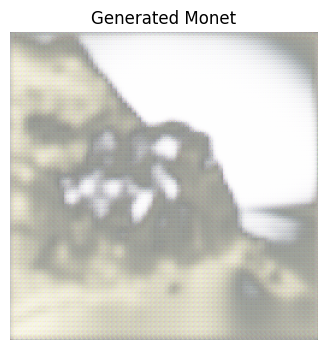

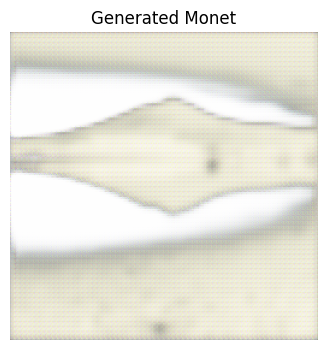

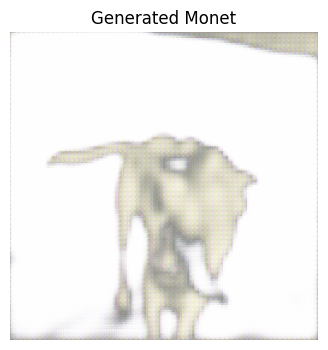

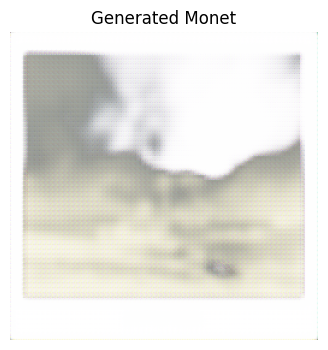

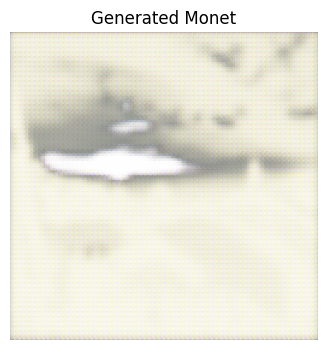

In [8]:
import matplotlib.pyplot as plt

# Function to generate and display a fake Monet painting from a photo
def generate_image(image):
    fake_image = generator_g(image, training=False)  # Ensure training=False for inference
    plt.figure(figsize=(4, 4))
    plt.imshow(fake_image[0] * 0.5 + 0.5)  # Rescale pixel values to [0, 1] if needed
    plt.axis('off')
    plt.title("Generated Monet")
    plt.show()

# Generate and display fake Monet paintings for the first 5 images in the photo dataset
for photo in photo_dataset.take(5):
    generate_image(photo)


# Slide 19: Evaluating the Results

Visualize generated images.

*   List item
*   List item


Discuss challenges and improvements.